<b> <font size="+2.5"> Enrichment of age-associated genes <br> in genes dysregulated in psychiatric disease
 </b> </font> <br>

Date: 20240118 <br>
Authors: ASF

# Load libraries

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(readr)
library(readxl)
library(GeneOverlap)
library(cowplot)
library(writexl)
library(viridis)
})

# Read in genes associated with Age

In [2]:
celltypes <- c('Exc_L2-3','Exc_L3-5','Exc_L4-6_1','Exc_L4-6_2','Exc_L4-6_3','Exc_L5-6_1','Exc_L5-6_2','Exc_L5-6_HTR2C',
               'In_LAMP5_1','In_LAMP5_2','In_PVALB_Ba','In_PVALB_Ch','In_RELN','In_SST','In_VIP','Astro_FB','Astro_PP',
               'Endothelial','Microglia','Oligodendrocyte','OPC')

# Age
DE_Age_results <- list()
for (celltype in celltypes){
  DE_Age_results[[celltype]] <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_20231121.xlsx', sheet = celltype))
}

#get significant hits at FDR < 0.1
DE_Age_genes <- list()
for (celltype in celltypes){
    DE_Age_genes[[celltype]] <- DE_Age_results[[celltype]][DE_Age_results[[celltype]]$adj.P.Val < 0.1,]
}

# split in up- and downregulate
DE_Age_genes_up <- list()
DE_Age_genes_down <- list()
for (celltype in celltypes){
    DE_Age_genes_up[[celltype]] <- DE_Age_genes[[celltype]][DE_Age_genes[[celltype]]$logFC > 0,]
    DE_Age_genes_down[[celltype]] <- DE_Age_genes[[celltype]][DE_Age_genes[[celltype]]$logFC < 0,]
}

# Read in genes associated with psychiatric disease

In [3]:
# psychiatric disease
DE_res_Disease_list <- list()
for (celltype in celltypes){
  DE_res_Disease_list[[celltype]] <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Disease_20231121.xlsx', sheet = celltype))
}

# perform multiple testing correction only within each cell type (not across all tested genes of all cell types)
DE_res_Disease_list_within_celltype_corr <- list()
for (celltype in names(DE_res_Disease_list)){
    tmp <- DE_res_Disease_list[[celltype]]
    tmp$p.adj_within_celltype <- p.adjust(tmp$P.Value, method='fdr', n=length(tmp$P.Value))
    DE_res_Disease_list_within_celltype_corr[[celltype]] <- tmp
}

compiled <- dplyr::bind_rows(DE_res_Disease_list_within_celltype_corr)

df_de_Disease <- compiled %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
        nDE_p_val_0.001 = sum(P.Value < 0.001),
        nDE_0.05_within_celltype = sum(p.adj_within_celltype < 0.05),
        nDE_0.1_within_celltype = sum(p.adj_within_celltype < 0.1)) %>%
        mutate(assay = factor(assay))  
df_de_Disease[4:8,]

# get significant disease hits
DE_Disease_genes <- list()
for (celltype in celltypes){
    tmp <- DE_res_Disease_list_within_celltype_corr[[celltype]][
        DE_res_Disease_list_within_celltype_corr[[celltype]]$p.adj_within_celltype < 0.1,]
    if (dim(tmp)[1] < 1) {next}
    else {DE_Disease_genes[[celltype]] <- tmp} 
}

# split in up- and downregulated
DE_Disease_genes_up <- list()
DE_Disease_genes_down <- list()
for (celltype in celltypes){
    DE_Disease_genes_up[[celltype]] <- DE_Disease_genes[[celltype]][DE_Disease_genes[[celltype]]$logFC > 0,]
    DE_Disease_genes_down[[celltype]] <- DE_Disease_genes[[celltype]][DE_Disease_genes[[celltype]]$logFC < 0,]
}

assay,nGenes_tested,nDE_0.1,nDE_0.05,nDE_p_val_0.001,nDE_0.05_within_celltype,nDE_0.1_within_celltype
<fct>,<int>,<int>,<int>,<int>,<int>,<int>
Exc_L2-3,18044,7,2,120,27,67
Exc_L3-5,8799,0,0,12,0,0
Exc_L4-6_1,12959,10,6,123,50,108
Exc_L4-6_2,12356,3,0,68,9,24
Exc_L4-6_3,9923,1,0,40,0,13


## Perform overlap between age-associated and disease-associated genes

In [4]:
### determine whether overlap of Disease Genes and Age Genes is significant
Age_Disease_overlap_test <- list()

for (celltype in names(DE_Disease_genes)){
    overlap <- newGeneOverlap(DE_Disease_genes[[celltype]]$ID, DE_Age_genes[[celltype]]$ID,genome.size=length(DE_Age_results[[celltype]]$ID))
    Age_Disease_overlap_test[[celltype]] <- testGeneOverlap(overlap) 
}

Age_Disease_overlap_test_table <- as.data.frame(matrix(ncol=7, nrow=length(names(DE_Disease_genes))))
colnames(Age_Disease_overlap_test_table) <- c('celltype', 'Disease DE genes', 'Age DE genes', 'n overlap genes', 'Genome size', 'overlap p-value', 'Odds Ratio' )
rownames(Age_Disease_overlap_test_table) <- names(DE_Disease_genes)

for (celltype in names(DE_Disease_genes)){
    Age_Disease_overlap_test_table[celltype,]$`celltype` <- celltype
    Age_Disease_overlap_test_table[celltype,]$`Disease DE genes` <- length(Age_Disease_overlap_test[[celltype]]@listA)
    Age_Disease_overlap_test_table[celltype,]$`Age DE genes` <- length(Age_Disease_overlap_test[[celltype]]@listB)
    Age_Disease_overlap_test_table[celltype,]$`n overlap genes` <- length(Age_Disease_overlap_test[[celltype]]@intersection)
    Age_Disease_overlap_test_table[celltype,]$`Genome size` <- Age_Disease_overlap_test[[celltype]]@genome.size
    Age_Disease_overlap_test_table[celltype,]$`overlap p-value` <- Age_Disease_overlap_test[[celltype]]@pval
    Age_Disease_overlap_test_table[celltype,]$`Odds Ratio` <- Age_Disease_overlap_test[[celltype]]@odds.ratio
}

# calculate the fdr adjusted p-value
Age_Disease_overlap_test_table$p.adjust_FDR <- p.adjust(Age_Disease_overlap_test_table$`overlap p-value`, 
                                                      method = 'fdr', n = length(Age_Disease_overlap_test_table$`overlap p-value`))

Age_Disease_overlap_test_table

,celltype,Disease DE genes,Age DE genes,n overlap genes,Genome size,overlap p-value,Odds Ratio,p.adjust_FDR
,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
Exc_L2-3,Exc_L2-3,67,1925,14,17910,1.076502e-02,2.202095,1.435336e-02
Exc_L4-6_1,Exc_L4-6_1,108,955,30,12872,1.329352e-10,4.921514,5.317406e-10
Exc_L4-6_2,Exc_L4-6_2,24,1156,4,12284,1.843829e-01,1.928413,1.843829e-01
Exc_L4-6_3,Exc_L4-6_3,13,469,6,9866,1.441577e-05,17.375321,2.883154e-05


In [5]:
combined_Age_Disease_list <- list()
for (celltype in names(DE_Disease_genes)){
    combined_Age_Disease_list[[celltype]] <- merge(DE_Age_genes[[celltype]], DE_Disease_genes[[celltype]], by='ID')
}

## Supplementary Table 13

In [6]:
Age_Disease_overlap_test_table
library(writexl)
#write_xlsx(Age_Disease_overlap_test_table, '../results/dreamlet_tables/final_celltypes_N87/Age_Disease_overlap_test_table.xlsx', col_names = TRUE)

,celltype,Disease DE genes,Age DE genes,n overlap genes,Genome size,overlap p-value,Odds Ratio,p.adjust_FDR
,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
Exc_L2-3,Exc_L2-3,67,1925,14,17910,1.076502e-02,2.202095,1.435336e-02
Exc_L4-6_1,Exc_L4-6_1,108,955,30,12872,1.329352e-10,4.921514,5.317406e-10
Exc_L4-6_2,Exc_L4-6_2,24,1156,4,12284,1.843829e-01,1.928413,1.843829e-01
Exc_L4-6_3,Exc_L4-6_3,13,469,6,9866,1.441577e-05,17.375321,2.883154e-05


## Quantify of directionality of overlapping genes

In [7]:
#quantify how many go in the same direction
# Age up Status down
# Age down Status up

directionality_quantification <- as.data.frame(matrix(ncol=5, nrow=length(names(combined_Age_Disease_list))))
rownames(directionality_quantification ) <- names(combined_Age_Disease_list)
colnames(directionality_quantification ) <- c('celltype', 'common_up', 'common_down', 'up_Age_down_Status', 'down_Age_up_Status')


for (celltype in names(combined_Age_Disease_list)){
  tmp <- combined_Age_Disease_list[[celltype]]
  up <- tmp %>% filter(logFC.x > 0 & logFC.y > 0)
  down <- tmp %>% filter(logFC.x < 0 & logFC.y < 0)
  up_Age_down_Status <- tmp %>% filter(logFC.x > 0 & logFC.y < 0)
  down_Age_up_Status <- tmp %>% filter(logFC.x < 0 & logFC.y > 0)
  directionality_quantification[celltype, ]$celltype <- celltype
  directionality_quantification[celltype, ]$common_up <- length(up$ID)
  directionality_quantification[celltype, ]$common_down <- length(down$ID)
  directionality_quantification[celltype, ]$up_Age_down_Status <- length(up_Age_down_Status$ID)
  directionality_quantification[celltype, ]$down_Age_up_Status <- length(down_Age_up_Status$ID)
}
#directionality_quantification

directionality_quantification$total <- directionality_quantification$common_up + directionality_quantification$common_down + directionality_quantification$up_Age_down_Status + directionality_quantification$down_Age_up_Status
directionality_quantification$total_common <- directionality_quantification$common_up + directionality_quantification$common_down
directionality_quantification$total_divergent <- directionality_quantification$up_Age_down_Status +directionality_quantification$down_Age_up_Status
directionality_quantification$percentage_common <- directionality_quantification$total_common/directionality_quantification$total *100
directionality_quantification$percentage_divergent <- (directionality_quantification$up_Age_down_Status +directionality_quantification$down_Age_up_Status)/directionality_quantification$total *100
directionality_quantification

,celltype,common_up,common_down,up_Age_down_Status,down_Age_up_Status,total,total_common,total_divergent,percentage_common,percentage_divergent
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
Exc_L2-3,Exc_L2-3,1,11,0,2,14,12,2,85.71429,14.285714
Exc_L4-6_1,Exc_L4-6_1,14,15,0,1,30,29,1,96.66667,3.333333
Exc_L4-6_2,Exc_L4-6_2,3,0,0,1,4,3,1,75.00000,25.000000
Exc_L4-6_3,Exc_L4-6_3,1,5,0,0,6,6,0,100.00000,0.000000


[1] 1

[1] 75

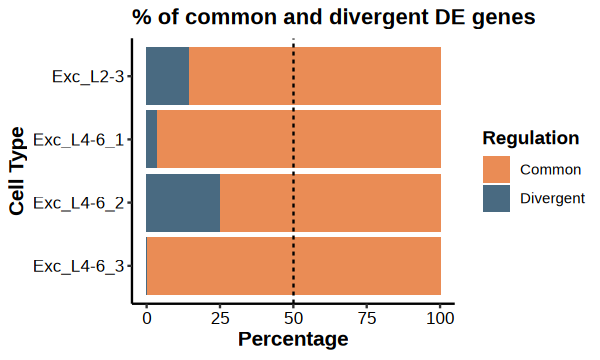

In [8]:
# what's the percentage of cell types with a common regulation higher than 50%?
length(which(directionality_quantification$percentage_common > 50))/length(directionality_quantification$percentage_common) # 100%

#minimum % common regulation
min(directionality_quantification$percentage_common)

directionality_quantification$celltype <- factor(directionality_quantification$celltype, 
                                                 levels=c("Exc_L4-6_3", "Exc_L4-6_2", 
                                                            "Exc_L4-6_1", "Exc_L2-3"))

long_quant <- directionality_quantification %>% 
  pivot_longer(
    cols = 9:10, 
    names_to = "Regulation",
    values_to = "Percentage"
  )

long_quant$Percentage <- round(long_quant$Percentage, digits = 1)
long_quant$Regulation <- ifelse(long_quant$Regulation == 'percentage_common', 'Common', 'Divergent')
long_quant$celltype <- factor(long_quant$celltype, levels=c("Exc_L4-6_3", "Exc_L4-6_2", 
                                                            "Exc_L4-6_1", "Exc_L2-3"))

long_quant$Regulation <- factor(long_quant$Regulation, levels=c('Common', 'Divergent'))

library(ggplot2)

options(repr.plot.width=5, repr.plot.height=3)
ggplot(data=long_quant, aes(x=celltype, y=Percentage, fill=Regulation)) + 
  geom_bar(position = 'stack', stat='identity') +
  coord_flip() + scale_fill_manual(values = c("#EA8C55", "#496A81") ) +xlab('Cell Type') +
ylab('Percentage') + ggtitle('% of common and divergent DE genes') + theme_classic() + 
theme(axis.text=element_text(size=10, color = 'black'),  axis.title=element_text(size=12,face="bold"),
      plot.title = element_text(size=13, face='bold'), legend.title=element_text(face='bold')) +
geom_hline(yintercept = 50, linetype="dashed", color = "black")

#ggsave('../figures/barplot_overlap_Age_&_Disease_genes_regulation.pdf', plot = last_plot(), width = 4, height =2.5)

## Extended Data Fig. 9d

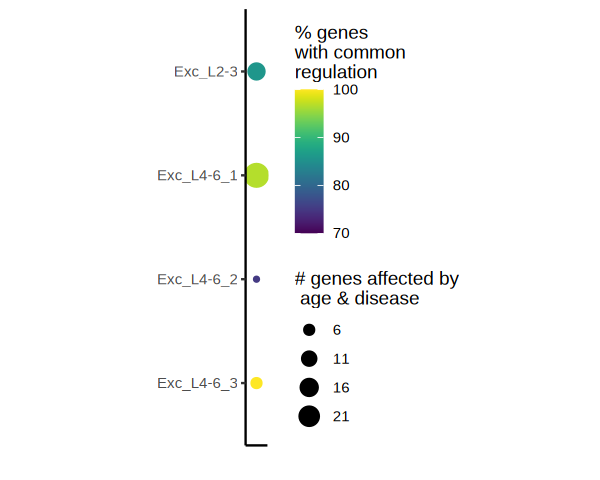

In [9]:
library(viridis)
options(repr.plot.width=5, repr.plot.height=4)
regulation = ggplot(directionality_quantification, aes(2, celltype)) +
        geom_tile(fill="white") +
        geom_point(aes(color=percentage_common, size=total)) +
scale_size_continuous(name = "# genes affected by\n age & disease", breaks=c(3, 6, 11, 16, 21)) +
        scale_color_viridis(name = "% genes\nwith common\nregulation", lim=c(70, NA)) +
        theme_classic() +
        theme(aspect.ratio=20, axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
        xlab('') + ylab('') 
regulation

#ggsave('../figures/plot_overlap_Age_&_Disease_genes_regulation.pdf', plot = last_plot(), width = 3, height =4.5)

In [10]:
# common upregulated
for (celltype in names(DE_Disease_genes)){
    print(paste0(celltype, ' up: ', intersect(DE_Disease_genes_up[[celltype]]$ID, DE_Age_genes_up[[celltype]]$ID))) 
    print(paste0(celltype, ' down: ', intersect(DE_Disease_genes_down[[celltype]]$ID, DE_Age_genes_down[[celltype]]$ID)))
}                                                                                                 

[1] "Exc_L2-3 up: ADCYAP1R1"
 [1] "Exc_L2-3 down: APLF"       "Exc_L2-3 down: AC034268.2"
 [3] "Exc_L2-3 down: AC005972.3" "Exc_L2-3 down: LINC02364" 
 [5] "Exc_L2-3 down: AL122014.1" "Exc_L2-3 down: AC097480.1"
 [7] "Exc_L2-3 down: EXPH5"      "Exc_L2-3 down: AC079385.1"
 [9] "Exc_L2-3 down: SLC22A10"   "Exc_L2-3 down: AC015943.1"
[11] "Exc_L2-3 down: AC093791.2"
 [1] "Exc_L4-6_1 up: SLIT2"      "Exc_L4-6_1 up: AC012404.1"
 [3] "Exc_L4-6_1 up: BTBD11"     "Exc_L4-6_1 up: CLMN"      
 [5] "Exc_L4-6_1 up: TRAF3IP2"   "Exc_L4-6_1 up: GPRIN3"    
 [7] "Exc_L4-6_1 up: ALDH3A2"    "Exc_L4-6_1 up: GALNT16"   
 [9] "Exc_L4-6_1 up: ADCYAP1R1"  "Exc_L4-6_1 up: SGPP2"     
[11] "Exc_L4-6_1 up: HRH3"       "Exc_L4-6_1 up: PLCXD2"    
[13] "Exc_L4-6_1 up: CTPS2"      "Exc_L4-6_1 up: AC058791.1"
 [1] "Exc_L4-6_1 down: LCN15"      "Exc_L4-6_1 down: LINC00507" 
 [3] "Exc_L4-6_1 down: HES4"       "Exc_L4-6_1 down: CENPF"     
 [5] "Exc_L4-6_1 down: KLHL5"      "Exc_L4-6_1 down: RCSD1"     
 [7] "Exc_L

# Read in genes associated with schizophrenia (Ruzicka et al. medrvix)

https://www.medrxiv.org/content/10.1101/2022.08.31.22279406v1 <br>
medRxiv preprint doi: https://doi.org/10.1101/2022.08.31.22279406; version posted September 2, 2022. <br>
accessed on 2024018

In [11]:
cts_Ruzicka <- c('Ex-L2', 'Ex-L23', 'Ex-L3', 'Ex-L4_MYLK', 'Ex-L45_MET', 'Ex-L45_LRRK1', 'Ex-L5b_HTR2C',
                 'Ex-L56', 'Ex-L56_CC_NTNG2', 'Ex-L6_CC_SEMA3A', 'Ex-L6b_SEMA3D', 'Ex-L6b_SEMA3E', 
                 'In-Rosehip_CHST9', 'In-Rosehip_TRPC3', 'In-Reelin', 'In-VIP', 'In-PV_Chandelier',
                 'In-PV_Basket', 'In-SST', 'Oli', 'OPC', 'Ast', 'Mic', 'Endo', 'Pericytes')

# SCZ DE
Ruzicka_SCZ <- list()
for (ct in cts_Ruzicka){
  Ruzicka_SCZ[[ct]] <- as.data.frame(read_excel('../external_datasets/Ruzicka_TableS4_DE_genes_merged_tables_medrxiv.xlsx', sheet = ct))
}

#get significant hits
# Meta-analysis identified a total of 6,634 differential expression events (FDR < 0.05 and |log2(fold change)| > 0.1)
DE_Ruzicka_SCZ <- list()
for (ct in cts_Ruzicka){
    DE_Ruzicka_SCZ[[ct]] <- Ruzicka_SCZ[[ct]][Ruzicka_SCZ[[ct]]$Meta_adj.P.Val < 0.05 & abs(Ruzicka_SCZ[[ct]]$Meta_logFC) > 0.1,]
}

# split in up- and downregulated
DE_Ruzicka_SCZ_up <- list()
DE_Ruzicka_SCZ_down <- list()
for (ct in cts_Ruzicka){
    DE_Ruzicka_SCZ_up[[ct]] <- DE_Ruzicka_SCZ[[ct]][DE_Ruzicka_SCZ[[ct]]$Meta_logFC > 0,]
    DE_Ruzicka_SCZ_down[[ct]] <- DE_Ruzicka_SCZ[[ct]][DE_Ruzicka_SCZ[[ct]]$Meta_logFC < 0,]
}

In [12]:
# number of DE genes match the numbers reported
for (ct in cts_Ruzicka){
    up_tmp <- dim(DE_Ruzicka_SCZ_up[[ct]])[1]
    down_tmp <- dim(DE_Ruzicka_SCZ_down[[ct]])[1]
    print(paste0(ct, ': upregulated genes: ', up_tmp, 
                 '; downregulated genes: ', down_tmp))
}

[1] "Ex-L2: upregulated genes: 135; downregulated genes: 251"
[1] "Ex-L23: upregulated genes: 186; downregulated genes: 362"
[1] "Ex-L3: upregulated genes: 67; downregulated genes: 375"
[1] "Ex-L4_MYLK: upregulated genes: 92; downregulated genes: 337"
[1] "Ex-L45_MET: upregulated genes: 66; downregulated genes: 402"
[1] "Ex-L45_LRRK1: upregulated genes: 112; downregulated genes: 246"
[1] "Ex-L5b_HTR2C: upregulated genes: 56; downregulated genes: 226"
[1] "Ex-L56: upregulated genes: 54; downregulated genes: 348"
[1] "Ex-L56_CC_NTNG2: upregulated genes: 29; downregulated genes: 54"
[1] "Ex-L6_CC_SEMA3A: upregulated genes: 57; downregulated genes: 595"
[1] "Ex-L6b_SEMA3D: upregulated genes: 79; downregulated genes: 662"
[1] "Ex-L6b_SEMA3E: upregulated genes: 41; downregulated genes: 297"
[1] "In-Rosehip_CHST9: upregulated genes: 23; downregulated genes: 86"
[1] "In-Rosehip_TRPC3: upregulated genes: 57; downregulated genes: 241"
[1] "In-Reelin: upregulated genes: 50; downregulated genes: 1

## Perform overlap of age and SCZ-associated genes

In [13]:
#cell type names matching
cts_Ruzicka <- c('Ex-L2', 'Ex-L23', 'Ex-L3', 'Ex-L4_MYLK', 'Ex-L45_MET', 'Ex-L45_LRRK1','Ex-L5b_HTR2C',
                 'Ex-L56', 'Ex-L56_CC_NTNG2', 'Ex-L6_CC_SEMA3A', 'Ex-L6b_SEMA3D',
                 'In-Rosehip_TRPC3', 'In-Rosehip_CHST9', 'In-Reelin', 'In-PV_Basket', 'In-PV_Chandelier','In-SST', 
                'In-VIP', 'Ast', 'Ast', 'Endo','Mic', 'Oli', 'OPC')

# names have to be unique; add *
names(cts_Ruzicka) <- c('Exc_L2-3', 'Exc_L2-3*', 'Exc_L3-5', 'Exc_L3-5*', 'Exc_L4-6_2','Exc_L4-6_1','Exc_L5-6_HTR2C',
                        'Exc_L5-6_1', 'Exc_L4-6_3', 'Exc_L4-6_3*', 'Exc_L5-6_1*', 'In_LAMP5_1','In_LAMP5_2', 
                        'In_RELN', 'In_PVALB_Ba', 'In_PVALB_Ch',"In_SST", 'In_VIP','Astro_FB', 'Astro_PP', 
                        'Endothelial', 'Microglia', 'Oligodendrocyte', 'OPC')

duplicated_cts <- c('Exc_L2-3', 'Exc_L3-5', 'Exc_L4-6_3', 'Exc_L5-6_1')
for (i in duplicated_cts){
    new_name <- paste0(i,"*")
    DE_Age_results[[new_name]] <- DE_Age_results[[i]]
    DE_Age_genes[[new_name]] <- DE_Age_genes[[i]]
    DE_Age_genes_up[[new_name]] <- DE_Age_genes[[new_name]][DE_Age_genes[[new_name]]$logFC >0,]
    DE_Age_genes_down[[new_name]] <- DE_Age_genes[[new_name]][DE_Age_genes[[new_name]]$logFC <0,]}

In [14]:
##### 
Ruzicka_overlap_test <- list()

idx <- 0
for (ct in cts_Ruzicka){
    idx <- idx +1
    celltype <- names(cts_Ruzicka)[idx]
    filtered <- DE_Ruzicka_SCZ[[ct]][DE_Ruzicka_SCZ[[ct]]$gene %in% DE_Age_results[[celltype]]$ID,] # remove genes not expressed in my dataset from the Ruzicka genes 
    overlap <-  newGeneOverlap(filtered$gene, DE_Age_genes[[celltype]]$ID,genome.size=length(DE_Age_results[[celltype]]$ID))
    Ruzicka_overlap_test[[celltype]] <- testGeneOverlap(overlap) }


Ruzicka_overlap_test_table <- as.data.frame(matrix(ncol=8, nrow=length(cts_Ruzicka)))
colnames(Ruzicka_overlap_test_table) <- c('celltype_Fröhlich', 'celltype_Ruzicka', 'SCZ DE genes Ruzicka et al.', 'Age DE genes Fröhlich et al.', 'n overlap genes', 'Genome size', 'overlap p-value', 'Odds Ratio' )
rownames(Ruzicka_overlap_test_table) <- names(cts_Ruzicka)

idx <- 0
for (celltype in names(cts_Ruzicka)){
    idx <- idx +1
    Ruzicka_overlap_test_table[celltype,]$`celltype_Fröhlich` <- celltype
    Ruzicka_overlap_test_table[celltype,]$`celltype_Ruzicka` <- cts_Ruzicka[idx]
    Ruzicka_overlap_test_table[celltype,]$`SCZ DE genes Ruzicka et al.` <- length(Ruzicka_overlap_test[[celltype]]@listA)
    Ruzicka_overlap_test_table[celltype,]$`Age DE genes Fröhlich et al.` <- length(Ruzicka_overlap_test[[celltype]]@listB)
    Ruzicka_overlap_test_table[celltype,]$`n overlap genes` <- length(Ruzicka_overlap_test[[celltype]]@intersection)
    Ruzicka_overlap_test_table[celltype,]$`Genome size` <- Ruzicka_overlap_test[[celltype]]@genome.size
    Ruzicka_overlap_test_table[celltype,]$`overlap p-value` <- Ruzicka_overlap_test[[celltype]]@pval
    Ruzicka_overlap_test_table[celltype,]$`Odds Ratio` <- Ruzicka_overlap_test[[celltype]]@odds.ratio
}

# calculate the fdr adjusted p-value
Ruzicka_overlap_test_table$p.adjust_FDR <- p.adjust(Ruzicka_overlap_test_table$`overlap p-value`, 
                                                      method = 'fdr', n = length(Ruzicka_overlap_test_table$`overlap p-value`))

head(Ruzicka_overlap_test_table)

,celltype_Fröhlich,celltype_Ruzicka,SCZ DE genes Ruzicka et al.,Age DE genes Fröhlich et al.,n overlap genes,Genome size,overlap p-value,Odds Ratio,p.adjust_FDR
,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
Exc_L2-3,Exc_L2-3,Ex-L2,378,1925,70,17910,3.697861e-06,1.920720,8.874866e-06
Exc_L2-3*,Exc_L2-3*,Ex-L23,540,1925,101,17910,1.630543e-08,1.960831,6.522173e-08
Exc_L3-5,Exc_L3-5,Ex-L3,429,323,38,8759,3.811857e-07,2.742910,1.143557e-06
Exc_L3-5*,Exc_L3-5*,Ex-L4_MYLK,419,323,51,8759,1.795143e-14,4.109593,2.154172e-13
Exc_L4-6_2,Exc_L4-6_2,Ex-L45_MET,461,1156,88,12284,5.747475e-11,2.375438,3.448485e-10
Exc_L4-6_1,Exc_L4-6_1,Ex-L45_LRRK1,353,955,80,12872,4.342644e-20,3.899297,1.042235e-18


In [15]:
# celltypes with significant overlap
sig_celltypes <- cts_Ruzicka[c(Ruzicka_overlap_test_table[Ruzicka_overlap_test_table$p.adjust_FDR < 0.05,]$`celltype_Fröhlich`)]
sig_celltypes
length(sig_celltypes)

Exc_L2-3          Exc_L2-3*           Exc_L3-5          Exc_L3-5* 
           "Ex-L2"           "Ex-L23"            "Ex-L3"       "Ex-L4_MYLK" 
        Exc_L4-6_2         Exc_L4-6_1         Exc_L5-6_1         Exc_L4-6_3 
      "Ex-L45_MET"     "Ex-L45_LRRK1"           "Ex-L56"  "Ex-L56_CC_NTNG2" 
       Exc_L4-6_3*        Exc_L5-6_1*         In_LAMP5_1            In_RELN 
 "Ex-L6_CC_SEMA3A"    "Ex-L6b_SEMA3D" "In-Rosehip_TRPC3"        "In-Reelin" 
       In_PVALB_Ba             In_SST             In_VIP           Astro_FB 
    "In-PV_Basket"           "In-SST"           "In-VIP"              "Ast" 
          Astro_PP          Microglia    Oligodendrocyte                OPC 
             "Ast"              "Mic"              "Oli"              "OPC"

[1] 20

## Supplementary Table 14

In [16]:
Ruzicka_overlap_test_table
library(writexl)
#write_xlsx(Ruzicka_overlap_test_table, '../results/dreamlet_tables/final_celltypes_N87/Age_SCZ(Ruzicka)_overlap_test_table.xlsx', col_names = TRUE)

,celltype_Fröhlich,celltype_Ruzicka,SCZ DE genes Ruzicka et al.,Age DE genes Fröhlich et al.,n overlap genes,Genome size,overlap p-value,Odds Ratio,p.adjust_FDR
,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
Exc_L2-3,Exc_L2-3,Ex-L2,378,1925,70,17910,3.697861e-06,1.920720,8.874866e-06
Exc_L2-3*,Exc_L2-3*,Ex-L23,540,1925,101,17910,1.630543e-08,1.960831,6.522173e-08
Exc_L3-5,Exc_L3-5,Ex-L3,429,323,38,8759,3.811857e-07,2.742910,1.143557e-06
Exc_L3-5*,Exc_L3-5*,Ex-L4_MYLK,419,323,51,8759,1.795143e-14,4.109593,2.154172e-13
Exc_L4-6_2,Exc_L4-6_2,Ex-L45_MET,461,1156,88,12284,5.747475e-11,2.375438,3.448485e-10
Exc_L4-6_1,Exc_L4-6_1,Ex-L45_LRRK1,353,955,80,12872,4.342644e-20,3.899297,1.042235e-18
Exc_L5-6_HTR2C,Exc_L5-6_HTR2C,Ex-L5b_HTR2C,236,104,8,4610,1.617684e-01,1.563395,1.848782e-01
Exc_L5-6_1,Exc_L5-6_1,Ex-L56,372,212,24,6618,7.573862e-04,2.221844,1.398251e-03
Exc_L4-6_3,Exc_L4-6_3,Ex-L56_CC_NTNG2,77,469,11,9866,9.692611e-04,3.394807,1.550818e-03


## Fig. 7b - Quantify of directionality of overlapping genes

In [17]:
# merge overlapping Age and SCZ genes
combined <- list()

idx <- 0
for (ct in sig_celltypes){
    idx <- idx +1
    celltype <- names(sig_celltypes)[idx]
    tmp <- DE_Ruzicka_SCZ[[ct]]
    colnames(tmp)[which(names(tmp) == 'gene')] <- 'ID'
    combined[[celltype]] <- merge(DE_Age_genes[[celltype]], tmp, by='ID')}
    

In [18]:
directionality_quantification <- as.data.frame(matrix(ncol=6, nrow=length(names(combined))))
rownames(directionality_quantification ) <- names(combined)
colnames(directionality_quantification ) <- c('celltype_Fröhlich', 'celltype_Ruzicka', 'common_up', 'common_down', 'up_Age_down_SCZ', 'down_Age_up_SCZ')

idx <- 0
for (ct in sig_celltypes){
    idx <- idx +1
    celltype <- names(sig_celltypes)[idx]
    tmp <- combined[[celltype]]
    up <- tmp %>% filter(logFC > 0 & Meta_logFC > 0)
    down <- tmp %>% filter(logFC < 0 & Meta_logFC < 0)
    up_Age_down_SCZ <- tmp %>% filter(logFC > 0 & Meta_logFC < 0)
    down_Age_up_SCZ <- tmp %>% filter(logFC < 0 & Meta_logFC > 0)
    directionality_quantification[celltype, ]$`celltype_Fröhlich` <- celltype
    directionality_quantification[celltype, ]$celltype_Ruzicka <- ct
    directionality_quantification[celltype, ]$common_up <- length(up$ID)
    directionality_quantification[celltype, ]$common_down <- length(down$ID)
    directionality_quantification[celltype, ]$up_Age_down_SCZ <- length(up_Age_down_SCZ$ID)
    directionality_quantification[celltype, ]$down_Age_up_SCZ <- length(down_Age_up_SCZ$ID)
}

directionality_quantification$total <- directionality_quantification$common_up + directionality_quantification$common_down + directionality_quantification$up_Age_down_SCZ + directionality_quantification$down_Age_up_SCZ
directionality_quantification$total_common <- directionality_quantification$common_up + directionality_quantification$common_down
directionality_quantification$total_divergent <- directionality_quantification$up_Age_down_SCZ +directionality_quantification$down_Age_up_SCZ
directionality_quantification$percentage_common <- directionality_quantification$total_common/directionality_quantification$total *100
directionality_quantification$percentage_divergent <- (directionality_quantification$up_Age_down_SCZ +directionality_quantification$down_Age_up_SCZ)/directionality_quantification$total *100
head(directionality_quantification)
dim(directionality_quantification)

,celltype_Fröhlich,celltype_Ruzicka,common_up,common_down,up_Age_down_SCZ,down_Age_up_SCZ,total,total_common,total_divergent,percentage_common,percentage_divergent
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
Exc_L2-3,Exc_L2-3,Ex-L2,8,53,2,7,70,61,9,87.14286,12.857143
Exc_L2-3*,Exc_L2-3*,Ex-L23,18,67,4,12,101,85,16,84.15842,15.841584
Exc_L3-5,Exc_L3-5,Ex-L3,2,33,2,1,38,35,3,92.10526,7.894737
Exc_L3-5*,Exc_L3-5*,Ex-L4_MYLK,6,45,0,0,51,51,0,100.00000,0.000000
Exc_L4-6_2,Exc_L4-6_2,Ex-L45_MET,8,76,2,2,88,84,4,95.45455,4.545455
Exc_L4-6_1,Exc_L4-6_1,Ex-L45_LRRK1,15,65,0,0,80,80,0,100.00000,0.000000


[1] 20 11

In [19]:
# what's the percentage of cell types with a common regulation higher than 50%?
length(which(directionality_quantification$percentage_common > 50))/length(directionality_quantification$percentage_common) # 100%

#minimum % common regulation
min(directionality_quantification$percentage_common)

[1] 1

[1] 81.81818

In [20]:
directionality_quantification$`celltype_Fröhlich` <- factor(directionality_quantification$`celltype_Fröhlich`, 
                                                         levels=rev(c('Exc_L2-3','Exc_L2-3*',
                                                                      'Exc_L3-5','Exc_L3-5*',
                                                                      'Exc_L4-6_2','Exc_L4-6_1',
                                                                      'Exc_L5-6_1','Exc_L4-6_3',
                                                                      'Exc_L4-6_3*','Exc_L5-6_1*',
                                                                      'In_LAMP5_1','In_RELN',
                                                                      'In_PVALB_Ba','In_SST',
                                                                      'In_VIP','Astro_FB','Astro_PP',
                                                                      'Microglia','Oligodendrocyte',
                                                                      'OPC')))

#celltype levels need to be unique
directionality_quantification[c('Astro_PP'),]$celltype_Ruzicka <- 'Ast*'
directionality_quantification$celltype_Ruzicka <- factor(directionality_quantification$celltype_Ruzicka ,
                                                         levels=rev(c('Ex-L2','Ex-L23','Ex-L3',
                                                                      'Ex-L4_MYLK','Ex-L45_MET',
                                                                      'Ex-L45_LRRK1','Ex-L56',
                                                                      'Ex-L56_CC_NTNG2','Ex-L6_CC_SEMA3A',
                                                                      'Ex-L6b_SEMA3D','In-Rosehip_TRPC3',
                                                                      'In-Reelin','In-PV_Basket','In-SST',
                                                                      'In-VIP','Ast','Ast*','Mic','Oli',
                                                                      'OPC')))

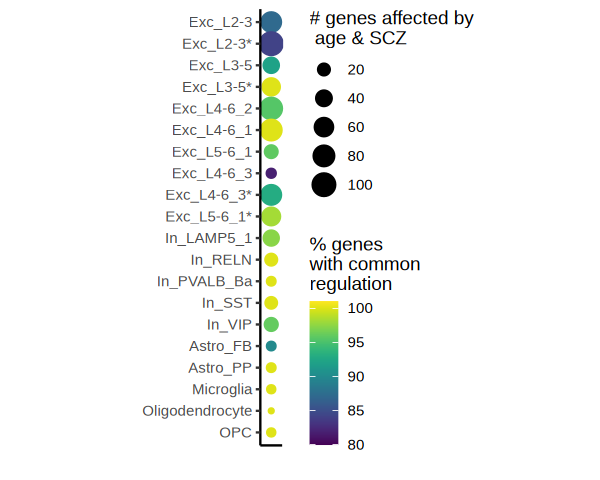

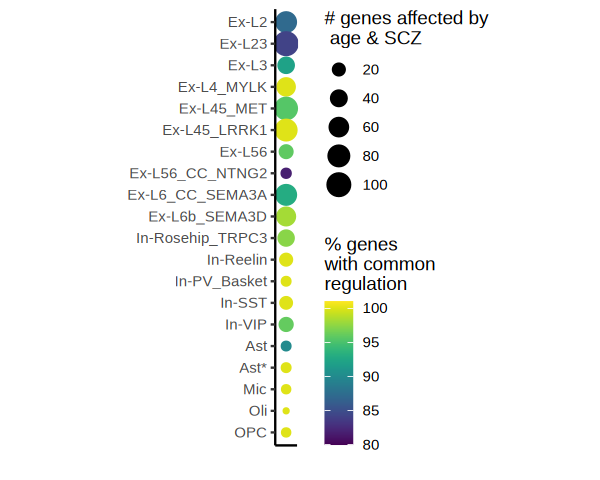

In [21]:
fig_list <- list()
fig_list[['celltype_labels_1']] = ggplot(directionality_quantification, aes(2, `celltype_Fröhlich`)) +
        geom_tile(fill="white") +
        geom_point(aes(color=percentage_common, size=total)) +
scale_size_continuous(name = "# genes affected by\n age & SCZ", breaks=c(0, 20, 40, 60, 80, 100)) +
        scale_color_viridis(name = "% genes\nwith common\nregulation", lim=c(80, 101)) +
        theme_classic() +
        theme(aspect.ratio=20, axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
        xlab('') + ylab('')

fig_list[['celltype_labels_2']] = ggplot(directionality_quantification, aes(2, celltype_Ruzicka)) +
        geom_tile(fill="white") +
        geom_point(aes(color=percentage_common, size=total)) +
scale_size_continuous(name = "# genes affected by\n age & SCZ", breaks=c(0, 20, 40, 60, 80, 100)) +
        scale_color_viridis(name = "% genes\nwith common\nregulation", lim=c(80, 101)) +
        theme_classic() +
        theme(aspect.ratio=20, axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
        xlab('') + ylab('') 

# Figure with cell type labels from this study
fig_list[['celltype_labels_1']]
ggsave('../figures/plot_overlap_Age_&_SCZ_Ruzicka_regulation_ct_label_1.pdf', plot = last_plot(), width = 5, height =4.5)
# Figure with cell type labels from Ruzicka et al.
fig_list[['celltype_labels_2']]
ggsave('../figures/plot_overlap_Age_&_SCZ_Ruzicka_regulation_ct_label_2.pdf', plot = last_plot(), width = 5, height =4.5)

## Calculate spearman correlation of logFCs of overlapping genes

In [22]:
# correlate logFCs
Ruzicka_spearman <- as.data.frame(matrix(ncol=5, nrow=length(sig_celltypes)))
colnames(Ruzicka_spearman) <- c('celltype_Fröhlich', 'celltype_Ruzicka', 'n_genes',
                                              'Rho', 'p-val')

merged <- list()
idx <- 0
for (ct in sig_celltypes){
    idx <- idx +1
    celltype <- names(sig_celltypes)[idx]
    tmp <- combined[[celltype]]
    if (dim(tmp)[1] >1){
        merged[[celltype]] <- cor.test(as.numeric(tmp$logFC), tmp$Meta_logFC, method=c("spearman"))
        Ruzicka_spearman$celltype_Fröhlich[idx] <- celltype
        Ruzicka_spearman$celltype_Ruzicka[idx] <- ct 
        Ruzicka_spearman$n_genes[idx] <- length(tmp$ID)
        Ruzicka_spearman$Rho[idx] <- merged[[celltype]]$estimate
        Ruzicka_spearman$`p-val`[idx] <- merged[[celltype]]$p.value
    }
} 

#adjust for multiple testing
Ruzicka_spearman$adj.P.Val <- p.adjust(Ruzicka_spearman$`p-val`, method='fdr', n=length(Ruzicka_spearman$`p-val`))

Ruzicka_spearman$`celltype_Fröhlich` <- factor(Ruzicka_spearman$`celltype_Fröhlich`, levels=Ruzicka_spearman$`celltype_Fröhlich`)

In [23]:
# significant spearman correlation:
length(Ruzicka_spearman[Ruzicka_spearman$adj.P.Val < 0.05,]$`celltype_Fröhlich`)

[1] 15

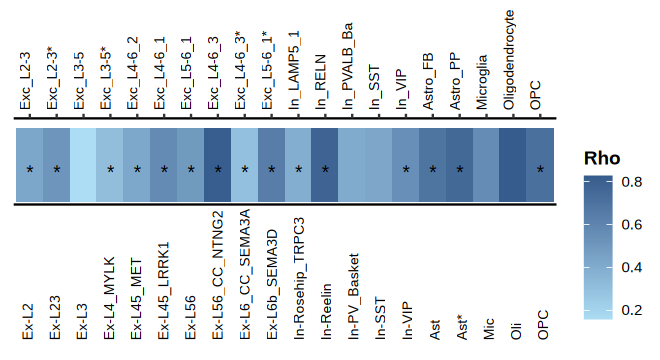

In [24]:
Ruzicka_spearman[Ruzicka_spearman$`celltype_Fröhlich` == 'Astro_PP',]$celltype_Ruzicka <- 'Ast*'

options(repr.plot.width=5.5, repr.plot.height=3)
ggplot(Ruzicka_spearman, aes(`celltype_Fröhlich`, 1, fill= Rho, label = ifelse(`adj.P.Val` < 0.05, "*", ""))) + 
  geom_tile() + theme_classic() + geom_text(vjust = 1, hjust = 0.5) +
  scale_fill_gradient(low = '#ACDDF4', high= '#365C8D') + theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=0, color="black", 
                                                                          size=8), axis.title.x=element_blank(),
                                               axis.text.y=element_blank(),axis.title.y=element_blank(), 
                                               axis.ticks.y=element_blank(), axis.line.y=element_blank(), 
                                               legend.title = element_text(face='bold')) + scale_x_discrete(position = "top") +
annotate(geom = "text", x = 1.1 + 1.01 * (0:19) , y = -1.42, angle=90, label =Ruzicka_spearman$`celltype_Ruzicka`, size = 2.9,
         vjust=0, hjust=0) + geom_hline(yintercept=0.45) 
ggsave('../figures/spearman_corr_Age_&_SCZ_Ruzicka_regulation.pdf', plot = last_plot(), width = 5, height =2.9)

# SessionInfo

In [25]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] viridis_0.6.4      viridisLite_0.4.2  writexl_1.4.2      cowplot_1.1.1     
 [5] GeneOverlap_1.38.0 readxl_1.4.3       lubridate_1.9.3    forcats_1.0.0     
 [9] stringr_1.5.1      dplyr_1.1.4        purrr_